In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from subprocess import check_output
print(check_output(["ls", "Data"]).decode("utf8"))
%matplotlib inline

sample_submission.csv
test.csv
train.csv



In [21]:
#load dataset

train = pd.read_csv("Data/train.csv")
print(train.shape)
print(train.head(5))

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0      

In [25]:
z_train = Counter(train["label"])
print(sorted(z_train.items()))

[(0, 4132), (1, 4684), (2, 4177), (3, 4351), (4, 4072), (5, 3795), (6, 4137), (7, 4401), (8, 4063), (9, 4188)]


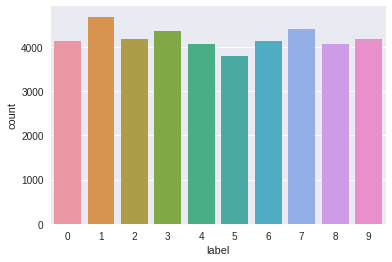

In [26]:
sns.countplot(train["label"])

In [27]:
#load the dataset for test

test = pd.read_csv("Data/test.csv")
print(test.shape)
print(test.head(5))

(28000, 784)
   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0

In [28]:
x_train = (train.iloc[:, 1:].values).astype("float32")
y_train = (train.iloc[:, 0].values).astype("int32")
x_test = test.values.astype("float32")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(42000, 784)
(42000,)
(28000, 784)


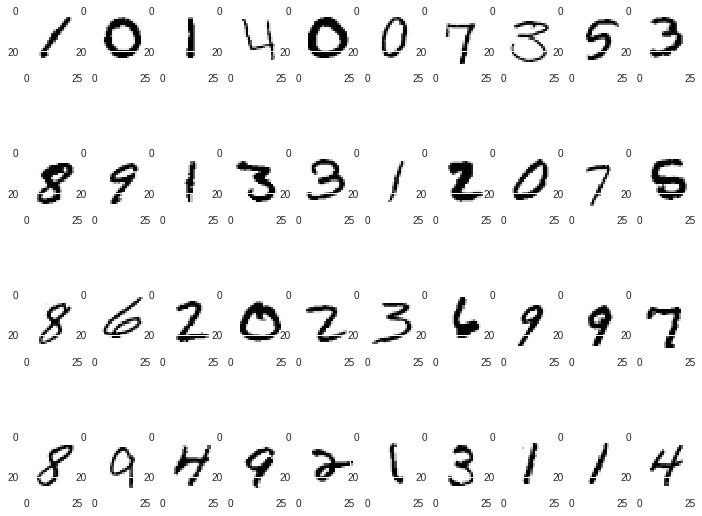

In [29]:
%matplotlib inline
#visualize some of the digits

plt.figure(figsize = (12,10))
x,y = 10,4
for i in range(40):
    plt.subplot(y,x,i+1)
    plt.imshow(x_train[i].reshape((28,28)), interpolation = "nearest")
plt.show()

In [30]:
#normalizing the data
x_train = x_train/255.0
x_test = x_test / 255.0


In [31]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

In [32]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
42000 train samples
28000 test samples


In [33]:
#reshape to match Keras's expectations

X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
print("alll imported.")

alll imported.


In [36]:
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28,28,1)

In [37]:
#cnvert class vectros to binary clas metrices with one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [38]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)


In [40]:
#Linear Model

model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), activation = "relu", kernel_initializer = "he_normal", input_shape = input_shape))
model.add(Conv2D(32, kernel_size = (3,3), activation = "relu", kernel_initializer = "he_normal"))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3,3), activation = "relu", padding = "same", kernel_initializer = "he_normal"))
model.add(Conv2D(64, (3,3), activation = "relu", padding = "same", kernel_initializer = "he_normal"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = "relu", padding = "same", kernel_initializer = "he_normal"))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation = "softmax"))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc", patience = 3, verbose = 1, factor = 0.5, min_lr = 0.0001)

datagen = ImageDataGenerator(
        featurewise_center = False, #set input mean to 0 over dataset
        samplewise_center = False, #set each sample mean to 0
        featurewise_std_normalization = False, #divide inputs by std of the dataset
        samplewise_std_normalization = False, #divide each intut by its std
        zca_whitening = False, #apply ZCA whitening
        rotation_range = 15,    #randomly rotate images in the range (egrees, 0 to 180)
        zoom_range = 0.1,       #randmly zoom image
        width_shift_range = 0.1, #randomly shift images horizontally (fraction to total width)
        height_shift_range = 0.1, #randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  #randomly flip images
        vertical_flip = False    #randomly flip images
    )

print("model created.")

model created.


In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [39]:
#Actual training the model. Do it in tesla with the gpu-enabled.

#datagen.fit(X_train)
#h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), epochs = epochs, validation_data = (X_val, Y_val), verbose = 1, steps_per_epoch = X_train.shape[0], callbacks = [learning_rate_reduction],)

In [47]:
#load the aleady trained model 

#from  keras.models import load_model

#model2 = load_model("model_epoch10.h5")  #did not work locally for whatever reason, but did work in Tesla

model.load_weights("Trained_model/model_epoch10_weights.h5")

#model2.summary()

In [48]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose = 0)
print("final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

final loss: 0.028537, final accuracy: 0.995000


(4200, 10)
(4200,)
(4200,)


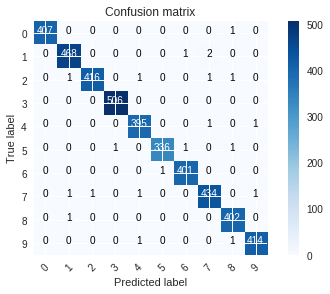

In [50]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
print(Y_pred.shape)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
print(Y_pred_classes.shape)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
print(Y_true.shape)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [53]:
#load model history
import pickle

hist = pickle.load(open("Trained_model/history_epoch10.pk","rb"))


dict_keys(['lr', 'acc', 'loss', 'val_acc', 'val_loss'])


dict_keys(['lr', 'acc', 'loss', 'val_acc', 'val_loss'])


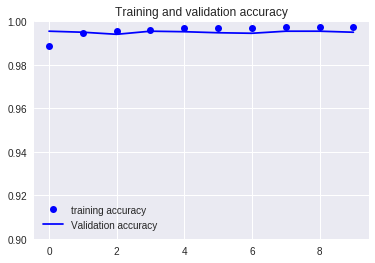

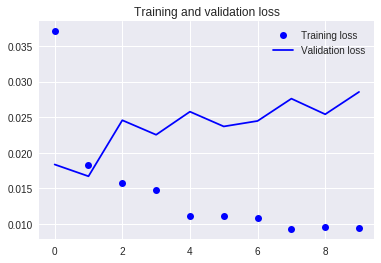

In [58]:
print(hist.keys())   #dict_keys(['lr', 'acc', 'loss', 'val_acc', 'val_loss'])

accuracy = hist["acc"]
val_accuracy = hist["val_acc"]
loss = hist["loss"]
val_loss = hist["val_loss"]
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, "bo", label = "training accuracy")
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.ylim(0.9, 1)
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
               
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
#lets manually examine some errors
errors = (Y_pred_classes - Y_true != 0)
print(errors.shape)
print(errors[:10])
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]
print(Y_pred_classes_errors.shape)
print(Y_pred_errors.shape)
print(Y_true_errors.shape)
print(X_val_errors.shape)

(4200,)
[False False False False False False False False False False]
(21,)
(21, 10)
(21,)
(21, 28, 28, 1)


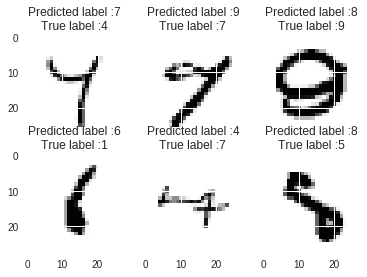

In [63]:
#show the errors
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

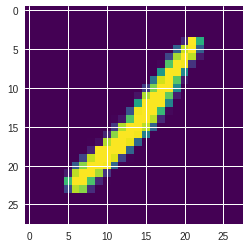

In [64]:
#visualizing the activations

test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')


total layers: 15
activations len: 8
first_layer_activation shape: (1, 26, 26, 32)


/home/osboxes/anaconda3/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  import sys


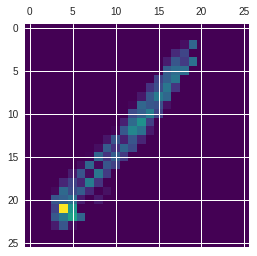

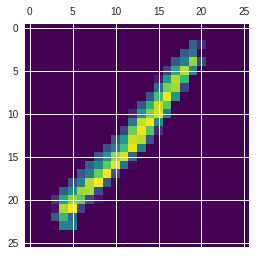

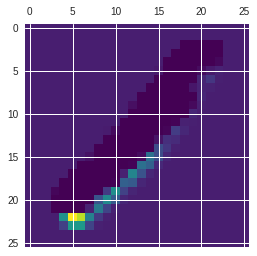

In [70]:
# Let's see the activation of the 2nd channel of the first layer:

from keras import models

print("total layers:", len(model.layers))  #15
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output = layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

print("activations len:", len(activations))

first_layer_activation = activations[0]
print("first_layer_activation shape:", first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 4], cmap = "viridis")  #just vizualizing different filters
plt.matshow(first_layer_activation[0, :, :, 0], cmap = "viridis")
plt.matshow(first_layer_activation[0, :, :, 1], cmap = "viridis")

In [71]:
# Let's plot the activations of the other conv layers as well.
model.layers[:-1]# Droping The Last Dense Layer

/home/osboxes/anaconda3/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


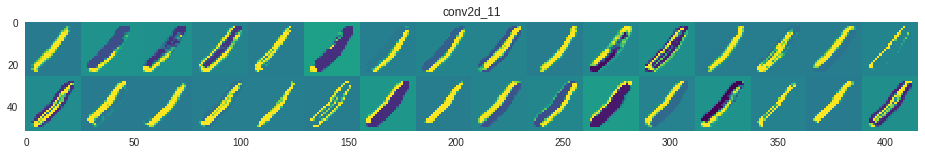

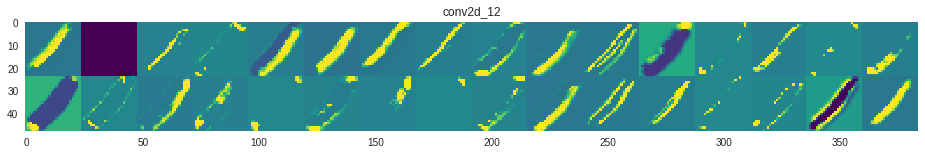

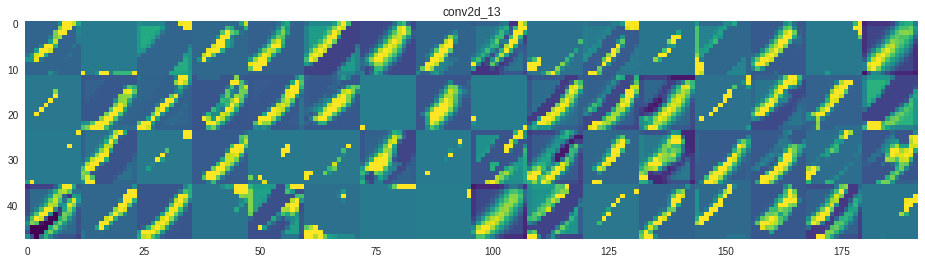

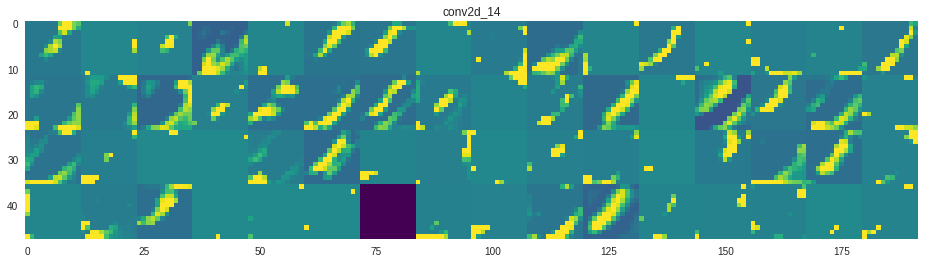

In [72]:
#this visualizes the conv layers

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/home/osboxes/anaconda3/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


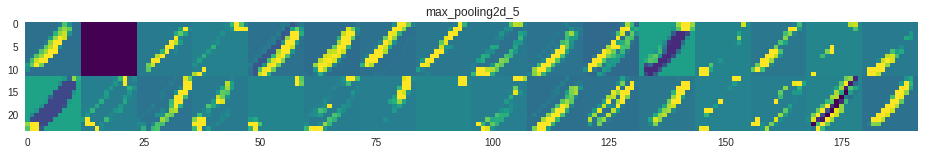

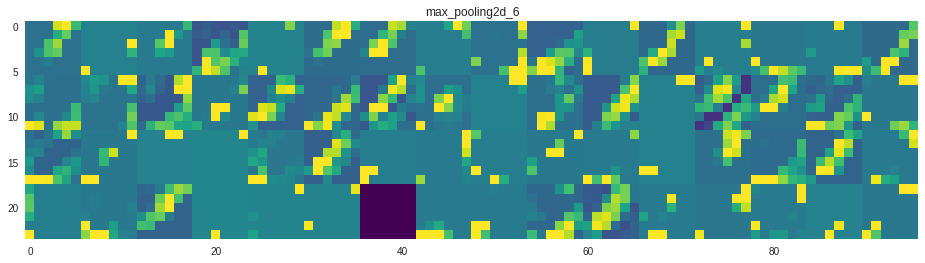

In [73]:
#this visualizes the maxpooling layers

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/home/osboxes/anaconda3/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


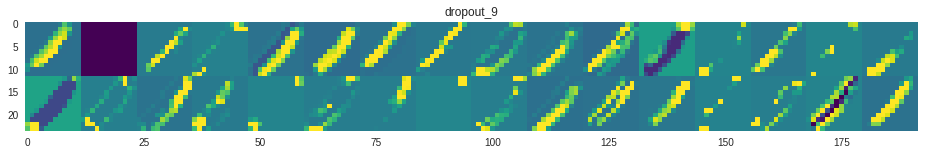

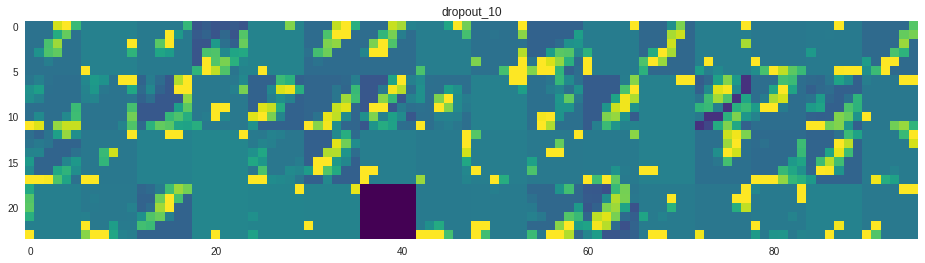

In [74]:
#dropout layers

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('drop'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [75]:
#classification layers

#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
print(predicted_classes.shape)

#get the indices to be plotted
y_true = test.iloc[:, 0]
print(y_true.shape)
correct = np.nonzero(predicted_classes==y_true)[0]
print(correct.shape)
incorrect = np.nonzero(predicted_classes!=y_true)[0]
print(incorrect.shape)

28000/28000 [==============================] - 275s   
(28000,)
(28000,)
(2766,)
(25234,)


In [77]:
#not sure why doing this

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       1.00      0.10      0.18     28000
    Class 1       0.00      0.00      0.00         0
    Class 2       0.00      0.00      0.00         0
    Class 3       0.00      0.00      0.00         0
    Class 4       0.00      0.00      0.00         0
    Class 5       0.00      0.00      0.00         0
    Class 6       0.00      0.00      0.00         0
    Class 7       0.00      0.00      0.00         0
    Class 8       0.00      0.00      0.00         0
    Class 9       0.00      0.00      0.00         0

avg / total       1.00      0.10      0.18     28000



/home/osboxes/anaconda3/envs/ztdl/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [78]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_classes)+1)),
                         "Label": predicted_classes})
submissions.to_csv("asd.csv", index=False, header=True)



In [79]:
model.save('my_model_1.h5')
json_string = model.to_json()